In [33]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [34]:
import numpy as np
import pandas as pd
import datetime as dt
import pandas as pd

## Reflect Tables into SQLALchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [36]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [38]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [41]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [42]:
#Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [43]:
# Get a list of column names and types
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])
# columns

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Bonus Challenge Assignment: Temperature Analysis II

In [44]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))
temp =calc_temps('2012-02-28', '2012-03-05')[0]

[(62.0, 69.57142857142857, 74.0)]


In [45]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

keys = ["Min", "Avg", "Max"]

dict_temps = {keys[i]: temp[i] for i in range(len(temp))}

temp_df = pd.DataFrame.from_dict(dict_temps, orient="index", columns=["Temp"])

temp_df

,Temp
Min,62.000000
Avg,69.571429
Max,74.000000


5.5
Avg   NaN
dtype: float64


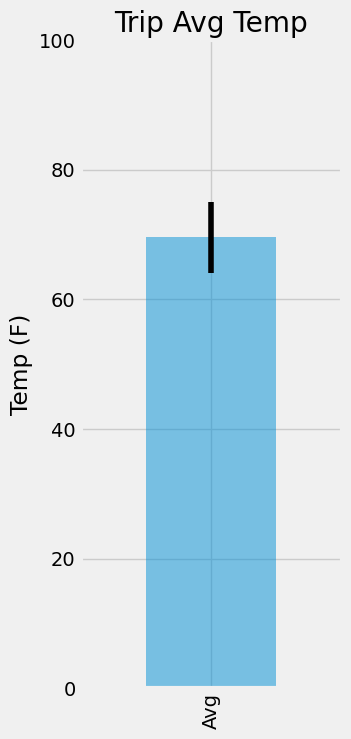

In [46]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
min_max = [72, 83]
tempstd = np.std(min_max)
error = tempstd
err = temp_df[1:2].sem(axis = 1)
print(error)
print(err)
# plot bar char
temp_df[1:2].plot(kind="bar", figsize=(3,8), ylim=(0,100),alpha=0.5, legend=False, yerr=error)
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.savefig("avgtemp_bonus.png")
plt.show()


### Daily Rainfall Average

In [47]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [48]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall=session.query(measurement.date, measurement.prcp).\
         filter(measurement.date<='2017-08-23').filter(measurement.date>='2016-08-23').\
         order_by(measurement.date).all()


In [49]:
#create a dataframe
rainfall_df = pd.DataFrame(rainfall, columns= ['date', 'prcp'])

rainfall_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
3,2016-08-23,NaN
4,2016-08-23,0.02


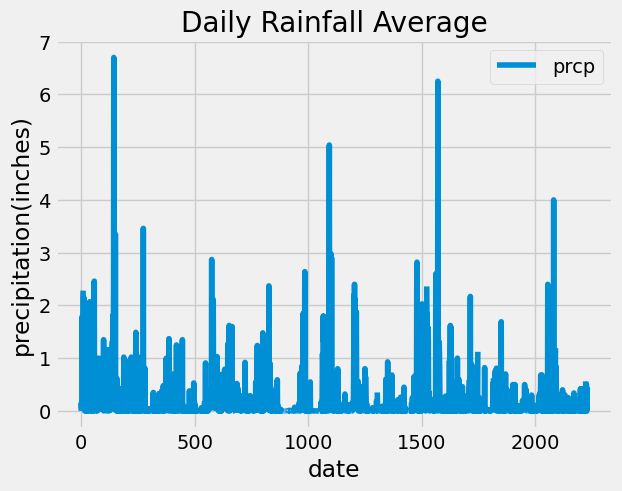

In [50]:
rainfall_df.plot()

#labels
plt.xlabel("date")
plt.ylabel("precipitation(inches)")
plt.title("Daily Rainfall Average")
plt.savefig("avg_rainfall.png")
plt.show()


# STATION ANALYSIS

In [51]:
#query to find the number of stations in the dataset
no_of_station = session.query(station.id).count()
no_of_station

9

In [52]:
#query the lists the stations and observation counts in descending order 
#To finds the most active station (USC00519281)
session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
# To query the min, max, and average temperatures for the most active station (USC00519281)
session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.station == 'USC00519281').all()

[(54.0, 71.66378066378067, 85.0)]

In [54]:
#query to get the previous 12 months of temperature observation 
#(TOBS) data that filters by the station that has the greatest number of observations
temp_obs_12= session.query(measurement.tobs).\
    filter(measurement.station == 'USC00519281').\
    filter(measurement.date >= '2016-08-23').all()



In [55]:
# assign the values to dataframe
temp_12 = pd.DataFrame(temp_obs_12, columns= ['tobs'])


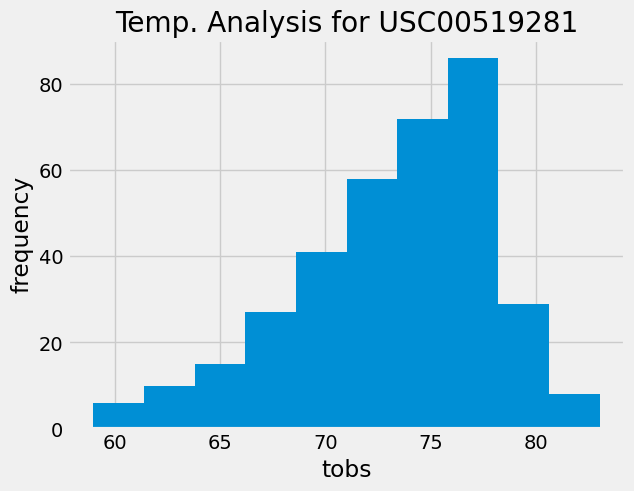

In [56]:
temp_12.hist()

#label
plt.xlabel("tobs")
plt.ylabel("frequency")
plt.title("Temp. Analysis for USC00519281")
plt.savefig("USC00519281.png")
plt.show()

# Daily Temperature Normals

In [87]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [95]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
#start_date = '2017-08-01'
#end_date = '2017-08-07'
# Use the start and end date to create a range of dates

lst = pd.date_range(start='2017-08-01', end='2017-08-07')


# Strip off the year and save a list of strings in the format %m-%d
date= lst.strftime("%m-%d")
date

Index(['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07'], dtype='object')

In [97]:
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`
results=[]
for i in date:
    results.append(daily_normals(i)[0])

results

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [101]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
temp_df=pd.DataFrame(results,columns=['min_temp','avg_temp','max_temp'],
                                   index=date)

temp_df.index.name='date'
temp_df


,min_temp,avg_temp,max_temp
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


<AxesSubplot:xlabel='date'>

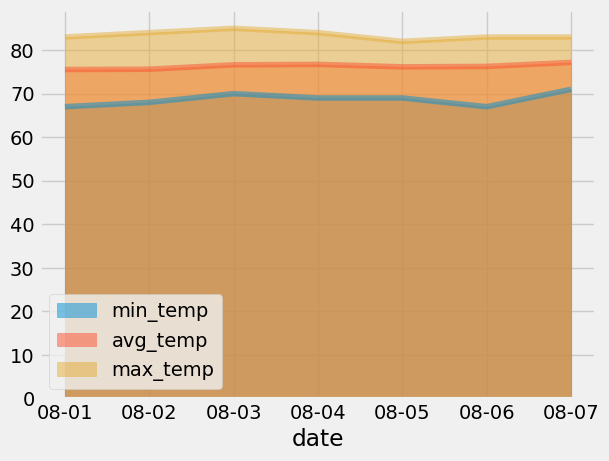

In [103]:
# Plot the daily normals as an area plot with `stacked=False`
temp_df.plot.area(stacked=False)

#labels
plt.xlabel("date")
plt.ylabel("Tmeperature")
plt.title("Daily Temperature at H")
plt.savefig("USC00519281.png")
plt.show()

## Close Session

In [ ]:
session.close()